# Example stitching workflow

Using a small example dataset with two positions.

In [1]:
VISUALIZE_USING_NAPARI = False

In [2]:
import os, tempfile
import numpy as np
from pathlib import Path
from tqdm import tqdm
import dask.diagnostics

from multiview_stitcher import sample_data, msi_utils
# %matplotlib notebook

2023-09-28 17:20:01,110 [Geometry3D WARNING] 'Renderer' is deprecated, using 'Visualizer' instead.


In [3]:
# Start a dask cluster

from distributed import Client, LocalCluster

lc = LocalCluster(n_workers=1, threads_per_worker=None)
client = Client(lc)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65167,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:65172,Total threads: 8
Dashboard: http://127.0.0.1:65173/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:65170,


In [4]:
# Load dataset from file

from multiview_stitcher import io

filename = Path('/Users/malbert/software/multiview-stitcher/image-datasets/arthur_20220621_premovie_dish2-max.czi')
sims = io.read_mosaic_image_into_list_of_spatial_xarrays(filename, scene_index=0)

msims = [msi_utils.get_store_decorator(
    filename.with_suffix('.tile%03d.zarr' %isim), store_overwrite=False)(
        msi_utils.get_msim_from_sim)(sim, [])
    for isim, sim in tqdm(enumerate(sims))]

# msims = [msi_utils.get_msim_from_sim(sim, scale_factors=[]) for sim in sims]
print(f"Loaded {len(msims)} positions from {filename}. Transform key is {io.METADATA_TRANSFORM_KEY}.")

# consider only first tp
# msims = [msi_utils.multiscale_sel_coords(msim, {'t':0}) for msim in msims]

# Test with generated dataset

# sims = sample_data.generate_tiled_dataset(
#     ndim=2,
#     N_t=1,
#     N_c=1,
#     tile_size=1000,
#     tiles_x=5,
#     tiles_y=5,
#     zoom=4,
#     overlap=30,
#     drift_scale=0,
#     shift_scale=15,
# )


9it [00:00, 11.80it/s]

Loaded 9 positions from /Users/malbert/software/ngff-stitcher/image-datasets/arthur_20220621_premovie_dish2-max.czi. Transform key is affine_metadata.


In [5]:
if VISUALIZE_USING_NAPARI:

    from napari_stitcher import viewer_utils
    import importlib
    viewer_utils = importlib.reload(viewer_utils)
    
    import napari
    viewer = napari.Viewer()
    
    layer_tuples = viewer_utils.create_image_layer_tuples_from_msims(
        msims, n_colors=2, transform_key='affine_metadata')
    viewer_utils.add_image_layer_tuples_to_viewer(viewer, layer_tuples)
    viewer.reset_view()

In [6]:
type(msims[0]['scale0/image'])

xarray.core.dataarray.DataArray

In [7]:
from multiview_stitcher import registration, fusion, mv_graph

import importlib
registration = importlib.reload(registration)
mv_graph = importlib.reload(mv_graph)

print('Registering...')
with dask.diagnostics.ProgressBar():
    params = registration.register(
        msims[:], transform_key='affine_metadata', reg_channel_index=0)

for msim, param in zip(msims, params):
    msi_utils.set_affine_transform(msim, param, transform_key='affine_registered', base_transform_key='affine_metadata')

Registering...


In [79]:
import importlib
from multiview_stitcher import transformation
fusion = importlib.reload(fusion)
transformation = importlib.reload(transformation)

print('Fusing...')
# with dask.config.set(scheduler='single-threaded')
with dask.diagnostics.ProgressBar():
    fused = fusion.fuse(
        [msi_utils.get_sim_from_msim(msim) for imsim, msim in enumerate(msims[1:3])],
        # [msi_utils.get_sim_from_msim(msim) for imsim, msim in enumerate([msims[0], msims[1]])],
        transform_key='affine_registered')#.compute()

# mfused = msi_utils.get_msim_from_sim(fused, scale_factors=[])

Fusing...


4it [00:00, 29.36it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2


8it [00:00, 34.25it/s]

(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2


12it [00:00, 35.61it/s]

(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2


20it [00:00, 34.83it/s]

(2, 4) 2
(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2


24it [00:00, 34.26it/s]

(3, 4) 2
(3, 5) 2


24it [00:00, 34.40it/s]
3it [00:00, 27.06it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2


6it [00:00, 26.87it/s]

(1, 0) 2


11it [00:00, 32.66it/s]

(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2


16it [00:00, 35.98it/s]

(2, 4) 2
(2, 5) 2
(3, 0) 2


24it [00:00, 31.94it/s]

(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2



0it [00:00, ?it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2


11it [00:00, 35.17it/s]

(0, 3) 2
(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2


20it [00:00, 35.10it/s]

(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2


24it [00:00, 33.95it/s]


(3, 5) 2


4it [00:00, 30.93it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1)

9it [00:00, 39.61it/s]

 2
(1, 2) 2
(1, 3) 2
(1, 4) 2


14it [00:00, 37.94it/s]

(1, 5) 2
(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 0) 2


24it [00:00, 34.82it/s]

(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2



0it [00:00, ?it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2


12it [00:00, 35.26it/s]

(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2


24it [00:00, 34.05it/s]

(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2



6it [00:00, 28.03it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2


16it [00:00, 39.70it/s]

(1, 4) 2
(1, 5) 2
(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2


24it [00:01, 14.55it/s]


(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2


0it [00:00, ?it/s]

(0, 0) 2
(0, 1) 2


8it [00:00, 36.27it/s]

(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2


13it [00:00, 37.28it/s]

(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2


18it [00:00, 39.40it/s]

(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2


22it [00:00, 36.91it/s]

(3, 3) 2
(3, 4) 2
(3, 5) 2


24it [00:00, 36.41it/s]
0it [00:00, ?it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2


4it [00:00, 32.52it/s]

(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2


9it [00:00, 40.35it/s]

(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2


18it [00:00, 38.45it/s]

(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2


24it [00:00, 36.60it/s]


(3, 4) 2
(3, 5) 2


0it [00:00, ?it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2


8it [00:00, 36.56it/s]

(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2


18it [00:00, 41.11it/s]

(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2


23it [00:00, 37.96it/s]

(3, 4) 2


24it [00:00, 37.57it/s]


(3, 5) 2


8it [00:00, 36.05it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2


17it [00:00, 39.55it/s]

(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 0) 2
(3, 1) 2


24it [00:00, 35.94it/s]


(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2


4it [00:00, 31.75it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2


8it [00:00, 35.08it/s]

(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2


12it [00:00, 36.47it/s]

(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2


17it [00:00, 40.29it/s]

(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2


24it [00:00, 35.83it/s]


(3, 3) 2
(3, 4) 2
(3, 5) 2


0it [00:00, ?it/s]

(0, 0) 2
(0, 1) 2


3it [00:00, 29.85it/s]

(0, 2) 2
(0, 3) 2
(0, 4) 2


7it [00:00, 31.05it/s]

(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2


12it [00:00, 37.81it/s]

(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2


17it [00:00, 40.71it/s]

(2, 5) 2
(3, 0) 2
(3, 1) 2


22it [00:00, 35.56it/s]

(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2


24it [00:00, 34.56it/s]
0it [00:00, ?it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2


4it [00:00, 31.77it/s]

(0, 4) 2
(0, 5) 2
(1, 0) 2


12it [00:00, 37.47it/s]

(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2


17it [00:00, 41.08it/s]

(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2


22it [00:00, 36.78it/s]

(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2


24it [00:00, 36.41it/s]
4it [00:00, 32.32it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2


8it [00:00, 36.10it/s]

(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2


12it [00:00, 37.54it/s]

(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2


17it [00:00, 40.58it/s]

(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2


24it [00:00, 36.63it/s]

(3, 3) 2
(3, 4) 2
(3, 5) 2



4it [00:00, 31.15it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2


8it [00:00, 35.72it/s]

(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2


12it [00:00, 36.43it/s]

(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2


17it [00:00, 39.38it/s]

(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2


24it [00:00, 35.34it/s]


(3, 3) 2
(3, 4) 2
(3, 5) 2


4it [00:00, 32.05it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2


8it [00:00, 35.97it/s]

(1, 0) 2
(1, 1) 2


12it [00:00, 33.30it/s]

(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2


24it [00:00, 33.97it/s]

(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2



9it [00:00, 40.74it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2


14it [00:00, 39.53it/s]

(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2


24it [00:00, 37.43it/s]


(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2


0it [00:00, ?it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2


8it [00:00, 36.48it/s]

(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2


13it [00:00, 37.83it/s]

(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2


23it [00:00, 37.45it/s]

(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2


24it [00:00, 37.36it/s]


(3, 5) 2


4it [00:00, 33.03it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2


10it [00:00, 42.85it/s]

(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2
(2, 1) 2


16it [00:00, 44.64it/s]

(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2


24it [00:00, 36.84it/s]


(3, 3) 2
(3, 4) 2
(3, 5) 2


0it [00:00, ?it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2


10it [00:00, 40.41it/s]

(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2


16it [00:00, 44.71it/s]

(2, 4) 2
(2, 5) 2
(3, 0) 2


21it [00:00, 36.54it/s]

(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2
(3, 5) 2


24it [00:00, 36.50it/s]
0it [00:00, ?it/s]

(0, 0) 2


11it [00:00, 36.30it/s]

(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2
(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2


20it [00:00, 34.61it/s]

(1, 5) 2
(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2
(3, 3) 2
(3, 4) 2


24it [00:00, 34.05it/s]


(3, 5) 2


4it [00:00, 27.19it/s]

(0, 0) 2
(0, 1) 2
(0, 2) 2
(0, 3) 2
(0, 4) 2
(0, 5) 2


8it [00:00, 32.98it/s]

(1, 0) 2
(1, 1) 2
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2


12it [00:00, 35.32it/s]

(2, 0) 2
(2, 1) 2
(2, 2) 2
(2, 3) 2
(2, 4) 2


17it [00:00, 39.00it/s]

(2, 5) 2
(3, 0) 2
(3, 1) 2
(3, 2) 2


24it [00:00, 34.49it/s]

(3, 3) 2
(3, 4) 2
(3, 5) 2


(<Figure size 988.8x604.8 with 4 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x29e9e5c00>)

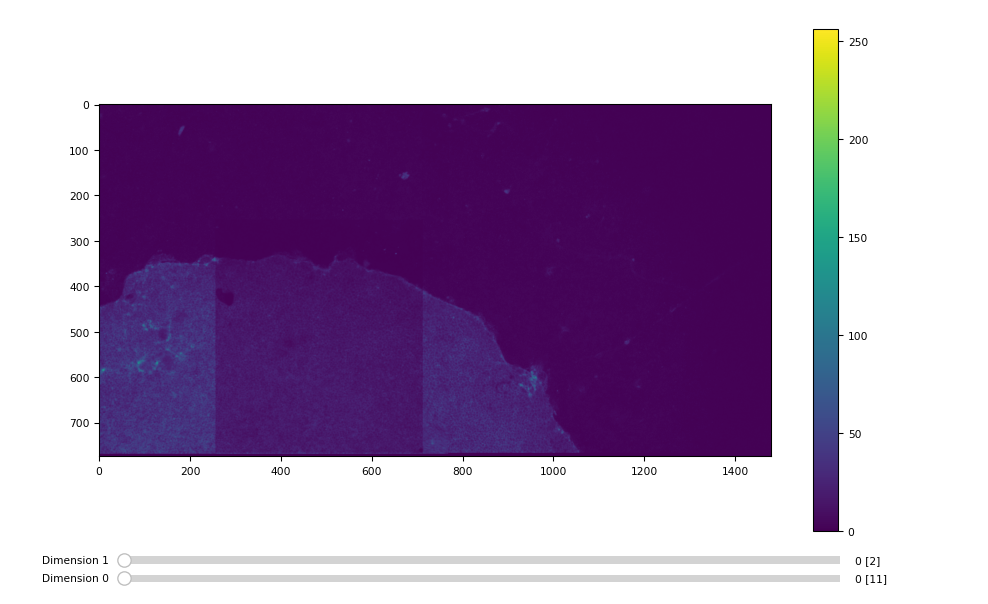

In [80]:
f=fused.compute()

%matplotlib widget
import tifffile
tifffile.imshow(np.array(f))

In [45]:
msi_utils.get_sim_from_msim(msims[0])

<xarray.DataArray 'image' (t: 11, c: 2, y: 768, x: 768)>
dask.array<open_dataset-12981766dff0185d241d35b0d1f06636image, shape=(11, 2, 768, 768), dtype=uint8, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U5 'EGFP' 'T-PMT'
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10
  * x        (x) float64 0.0 2.21 4.419 6.629 ... 1.69e+03 1.693e+03 1.695e+03
  * y        (y) float64 0.0 2.21 4.419 6.629 ... 1.69e+03 1.693e+03 1.695e+03
Attributes:
    transforms:  {'affine_metadata': <xarray.DataArray 'affine_metadata' (t: ...

In [11]:
if VISUALIZE_USING_NAPARI:
    
    viewer = napari.Viewer(ndisplay=2)

    # lds = viewer_utils.create_image_layer_tuples_from_msims(
    #     msims, transform_key='affine_metadata', n_colors=2,
    #     name_prefix='pre-registered view',
    #     contrast_limits=(0, 1000),
    #     )
    # mlayers = viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds, do_link_layers=True)

    lds = viewer_utils.create_image_layer_tuples_from_msims(
        msims, transform_key='affine_registered', n_colors=2,
        name_prefix='registered view',
        contrast_limits=(0, 1000),
        )
    mlayers = viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds, do_link_layers=True)

    lds = viewer_utils.create_image_layer_tuples_from_msim(
        mfused,
        transform_key='affine_registered',
        name_prefix='fused',
        contrast_limits=[0, 1000])

    viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds)



In [12]:
# with dask.diagnostics.ProgressBar():
#     io.save_sim_as_tif('fused.tif', fused)